# **Numerical APTOS2019 Dataset Notebook** 
###### _Dataset obtained from: https://www.kaggle.com/datasets/mariaherrerot/aptos2019/data?select=valid.csv_

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from PIL.ExifTags import TAGS
import os
import numpy as np
import cv2
from skimage import io, color
from skimage.feature import local_binary_pattern
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC

### Data Exploration:

In [2]:
# Viewing the first 5 rows of the 'train' csv file

feature_extraction_csv_file_path = os.path.join('..', '..', 'Data', 'APTOS-2019 Dataset', 'features_new_700_res_train.csv')

feature_extraction_df = pd.read_csv(feature_extraction_csv_file_path)

feature_extraction_df.head(6)

,Image Name,Exudates,Oedema,Vessel Count,Heamotomas,Bifurcations,Clarity,Diabetes Status
0,000c1434d8d7,25,0,8,4,41,0.843524,1
1,001639a390f0,5,0,19,2,82,0.884737,1
2,0024cdab0c1e,14,0,7,4,21,1.000000,1
3,002c21358ce6,2,0,20,7,82,1.000000,0
4,005b95c28852,150,0,14,1,18,0.357767,0
5,0083ee8054ee,372,0,18,2,51,1.000000,1


In [3]:
# The distrobution of the training data is given below

feature_extraction_df.describe()

,Exudates,Oedema,Vessel Count,Heamotomas,Bifurcations,Clarity,Diabetes Status
count,3296.000000,3296.0,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000
mean,59.505765,0.0,14.642900,3.010316,58.891687,0.822460,0.512743
std,90.142803,0.0,7.266208,3.753871,36.245933,0.231673,0.499913
min,0.000000,0.0,2.000000,0.000000,1.000000,0.136912,0.000000
25%,4.000000,0.0,9.000000,0.000000,33.000000,0.668302,0.000000
50%,25.000000,0.0,13.000000,2.000000,50.000000,0.979865,1.000000
75%,76.250000,0.0,19.000000,5.000000,76.000000,1.000000,1.000000
max,739.000000,0.0,51.000000,26.000000,259.000000,1.000000,1.000000


In [4]:
# Determining if there are any null values
feature_extraction_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3296 entries, 0 to 3295
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Image Name       3296 non-null   object 
 1   Exudates         3296 non-null   int64  
 2   Oedema           3296 non-null   int64  
 3   Vessel Count     3296 non-null   int64  
 4   Heamotomas       3296 non-null   int64  
 5   Bifurcations     3296 non-null   int64  
 6   Clarity          3296 non-null   float64
 7   Diabetes Status  3296 non-null   int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 206.1+ KB


In [5]:
# Check for missing values
print("\nMissing values in each column:")
display(feature_extraction_df.isnull().sum())


Missing values in each column:


Image Name         0
Exudates           0
Oedema             0
Vessel Count       0
Heamotomas         0
Bifurcations       0
Clarity            0
Diabetes Status    0
dtype: int64

In [6]:
# Check the data types of each column
print("\nData types of each column:")
display(feature_extraction_df.dtypes)


Data types of each column:


Image Name          object
Exudates             int64
Oedema               int64
Vessel Count         int64
Heamotomas           int64
Bifurcations         int64
Clarity            float64
Diabetes Status      int64
dtype: object


Histograms for numerical features:


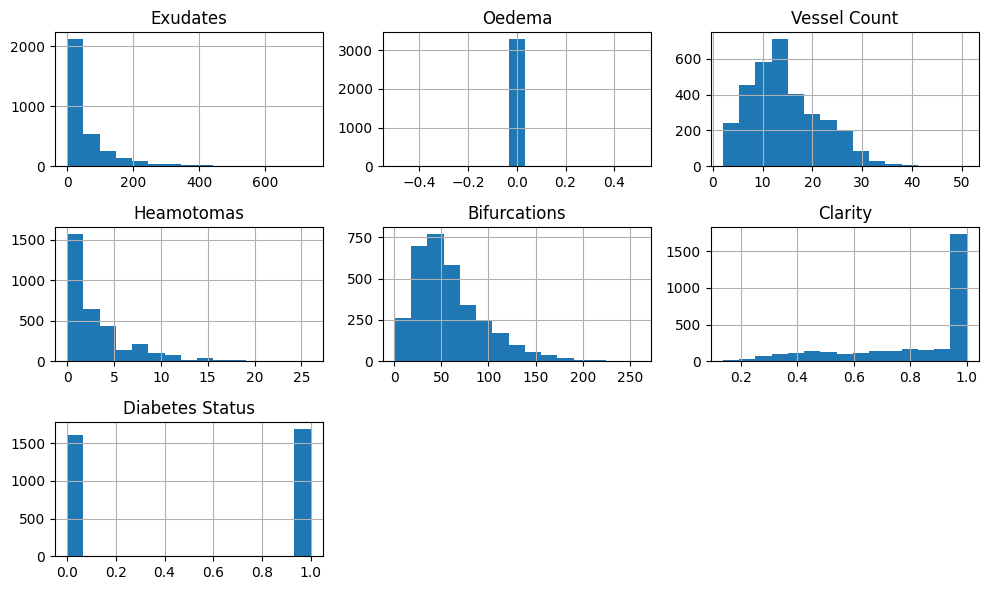

In [12]:
# Plot histograms for numerical features
print("\nHistograms for numerical features:")
numerical_columns = ['Exudates', 'Oedema', 'Vessel Count', 'Heamotomas', 'Bifurcations', 'Clarity', 'Diabetes Status']
feature_extraction_df[numerical_columns].hist(bins=15, figsize=(10, 6), layout=(3, 3))
plt.tight_layout()
plt.show()


Histograms for numerical features:


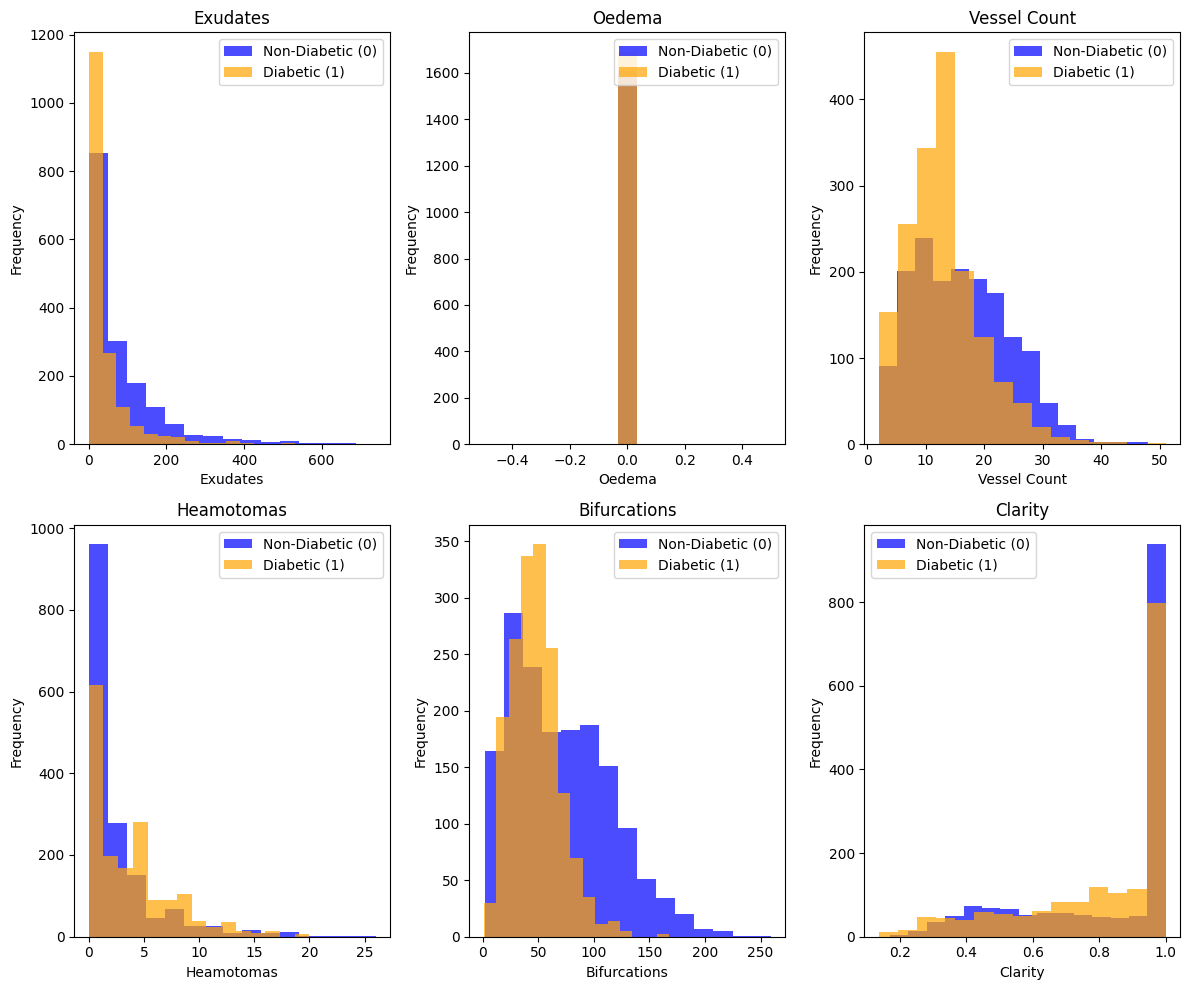

In [15]:
# Plot histograms for each numerical feature, separating by 'Diabetes Status'
print("\nHistograms for numerical features:")

# List of numerical columns (excluding the target column 'Diabetes Status')
numerical_columns = ['Exudates', 'Oedema', 'Vessel Count', 'Heamotomas', 'Bifurcations', 'Clarity']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()

# Loop through each numerical column and plot histograms for 'Diabetes Status = 0' and 'Diabetes Status = 1'
for i, col in enumerate(numerical_columns):
    axes[i].hist(
        feature_extraction_df[feature_extraction_df['Diabetes Status'] == 0][col], 
        bins=15, alpha=0.7, label='Non-Diabetic (0)', color='blue'
    )
    axes[i].hist(
        feature_extraction_df[feature_extraction_df['Diabetes Status'] == 1][col], 
        bins=15, alpha=0.7, label='Diabetic (1)', color='orange'
    )
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()



Correlation matrix:


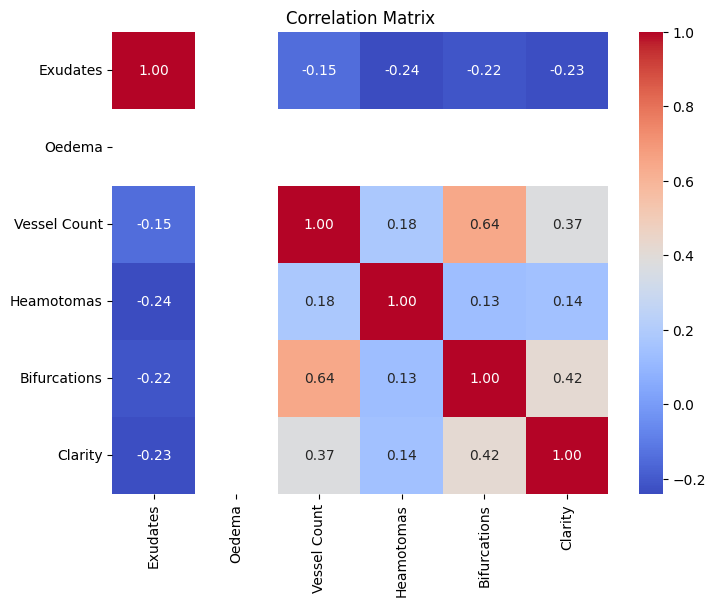

In [16]:
# Plot correlations between features
print("\nCorrelation matrix:")
correlation_matrix = feature_extraction_df[numerical_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [17]:
# Check for class distribution in the target column (e.g., 'Diabetes Status')
print("\nClass distribution of 'Diabetes Status':")
print(feature_extraction_df['Diabetes Status'].value_counts())


Class distribution of 'Diabetes Status':
Diabetes Status
1    1690
0    1606
Name: count, dtype: int64


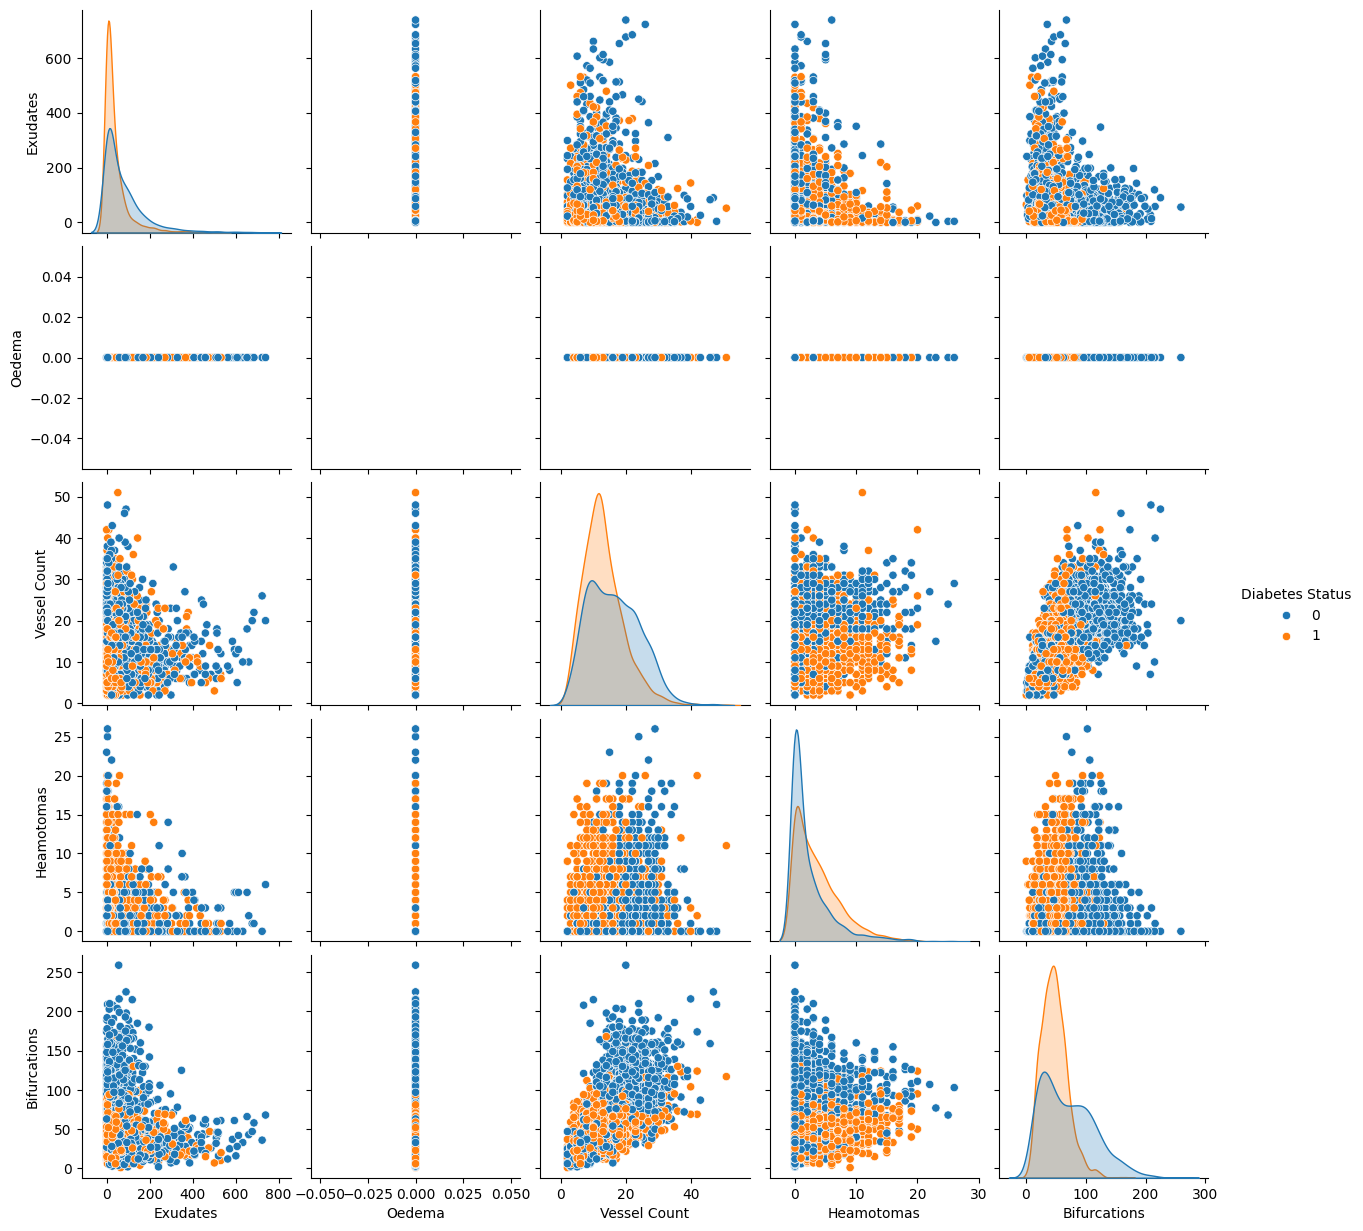

In [18]:
# Visualize the relationship between 'Diabetes Status' and other features
sns.pairplot(feature_extraction_df, hue='Diabetes Status', vars=numerical_columns[:-1])
plt.show()

### Preprocessing:

In [19]:
# Load the dataset (replace 'path_to_your_csv_file.csv' with the actual file path)
#data = os.path.join('..', '..', 'Data', 'APTOS-2019 Dataset', 'features_500_res.csv')
train_data = os.path.join('..', '..', 'Data', 'APTOS-2019 Dataset', 'features_new_700_res_train.csv')
test_data = os.path.join('..', '..', 'Data', 'APTOS-2019 Dataset', 'features_new_700_res_test.csv')

train_data = pd.read_csv(train_data)
test_data = pd.read_csv(test_data)

# Step 2: Separate features (X) and labels (y)
x = train_data.drop(columns=['Image Name', 'Diabetes Status'])  # Drop 'Image Name' as it's not a useful feature
y = train_data['Diabetes Status']  # This is the target variable

x_test = test_data.drop(columns=['Image Name', 'Diabetes Status'])  # Drop 'Image Name' as it's not a useful feature
y_test = test_data['Diabetes Status']  # This is the target variable

# Step 3: Split the data into train and test sets (70% train, 30% test)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)

print(f"Train set size: {x_train.shape[0]}")
print(f"Validation set size: {x_val.shape[0]}")


Train set size: 2307
Validation set size: 989


Standardise Dataset:

In [20]:
# Step 4: Standardize the numerical features
scaler = StandardScaler() 

# Fit the scaler on the training data and transform both the train and val data
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

x_test_scaled = scaler.fit_transform(x_test)

# Optional: Convert the scaled data back into DataFrame (for readability purposes)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x.columns)
x_val_scaled = pd.DataFrame(x_val_scaled, columns=x.columns)

x_test_scaled = pd.DataFrame(x_test_scaled, columns=x.columns)

# Display the first few rows of the scaled training data
print("\nScaled training data:")
display(x_train_scaled.head())


Scaled training data:


,Exudates,Oedema,Vessel Count,Heamotomas,Bifurcations,Clarity
0,-0.658725,0.0,-1.047146,-0.269123,-1.265572,-0.993747
1,0.281547,0.0,-0.633109,-0.800686,0.003240,0.001091
2,3.356787,0.0,-0.495097,-0.800686,-1.100075,-0.755610
3,0.303671,0.0,0.194964,-0.800686,3.699346,0.776794
4,-0.658725,0.0,1.437073,1.325567,2.430534,0.776794


Removing Oedema from the standardised dataset:

In [21]:
# Remove the 'Oedema' feature from both the training and validation sets
x_train_scaled = x_train_scaled.drop(columns=['Oedema'])
x_val_scaled = x_val_scaled.drop(columns=['Oedema'])
x_test_scaled = x_test_scaled.drop(columns=['Oedema'])

# Display the first few rows of the updated training data
print("\nTraining data after removing 'Oedema':")
display(x_train_scaled.head())

# Display the first few rows of the updated validation data
print("\nValidation data after removing 'Oedema':")
display(x_val_scaled.head())



Training data after removing 'Oedema':


,Exudates,Vessel Count,Heamotomas,Bifurcations,Clarity
0,-0.658725,-1.047146,-0.269123,-1.265572,-0.993747
1,0.281547,-0.633109,-0.800686,0.003240,0.001091
2,3.356787,-0.495097,-0.800686,-1.100075,-0.755610
3,0.303671,0.194964,-0.800686,3.699346,0.776794
4,-0.658725,1.437073,1.325567,2.430534,0.776794



Validation data after removing 'Oedema':


,Exudates,Vessel Count,Heamotomas,Bifurcations,Clarity
0,-0.105624,-1.323170,-0.800686,-1.017326,-2.594837
1,-0.614477,0.747013,0.794004,-0.051926,0.776794
2,-0.116686,0.885025,-0.534904,0.968641,0.776794
3,-0.083500,-1.047146,-0.003341,-0.520835,-2.146861
4,-0.658725,-1.047146,1.325567,-0.548418,-0.097407


Removing Oedema from the Original Dataset:

In [22]:
# Remove the 'Oedema' feature from both the training and validation sets
x_train = x_train.drop(columns=['Oedema'])
x_val = x_val.drop(columns=['Oedema'])
x_test = x_test.drop(columns=['Oedema'])

### Machine Learning Models:

##### Reuseable Functions for Plotting Model Statistics:

Function for Plotting Classifier Statistics:

In [23]:
# For tree-based classifiers, plots the confusion matrix, histogram of feature importance and ROC + Precision-Recall Curves

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import numpy as np
import seaborn as sns

def plot_model_evaluation_statistics(model, X_val, y_val):
    # Predict probabilities
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()

    # Feature Importance
    plt.figure(figsize=(6, 4))
    feature_importances = model.feature_importances_
    indices = np.argsort(feature_importances)[::-1] # Sorts feature importances in descending order and get the indices
    feature_names_sorted = X_val.columns[indices]  # Arranges feature names according to the indices

    plt.title('Feature Importances')
    plt.bar(range(X_val.shape[1]), feature_importances[indices], color="r", align="center")
    plt.xticks(range(X_val.shape[1]), feature_names_sorted, rotation=90)
    plt.xlim([-1, X_val.shape[1]])
    plt.show()


In [24]:
# For Linear-based Classifiers, plots the confusion matrix, histogram of feature importance and ROC + Precision-Recall Curves

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import numpy as np
import seaborn as sns

def plot_linear_model_evaluation_statistics(model, X_val, y_val):
    # Predict probabilities
    y_pred_prob = model.predict_proba(X_val)[:, 1]

    # Predict class labels
    y_pred = model.predict(X_val)

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()

    # Coefficients for Linear Model
    if hasattr(model, 'coef_'):
        plt.figure(figsize=(6, 4))
        coefficients = model.coef_[0]
        indices = np.argsort(np.abs(coefficients))[::-1]
        feature_names_sorted = X_val.columns[indices]

        plt.title('Feature Coefficients')
        plt.bar(range(len(indices)), coefficients[indices], color="r", align="center")
        plt.xticks(range(len(indices)), feature_names_sorted, rotation=90)
        plt.xlabel('Features')
        plt.ylabel('Coefficient Value')
        plt.tight_layout()
        plt.show()

Function for Plotting Regressor Statistics:

In [25]:
# Creates the same plots as done for the classifier models, however, also plots the histogram of predictions and uses the cut-off threshold to make predictions binary

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score
import numpy as np
import seaborn as sns

def plot_regression_evaluation_statistics(model, X_val, y_val, cutoff_threshold=0.5):
    # Continuous predictions
    y_pred_continuous = model.predict(X_val)

    # Convert continuous predictions to binary using the cutoff threshold
    y_pred_binary = np.where(y_pred_continuous > cutoff_threshold, 1, 0)

    # Calculate accuracy for the binary predictions
    accuracy = accuracy_score(y_val, y_pred_binary)
    print(f"Validation Accuracy (with cutoff {cutoff_threshold}): {accuracy:.4f}")

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_val, y_pred_binary)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_pred_continuous)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_val, y_pred_continuous)

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()

    # Feature Importance (if model supports it - Bayes does not)
    plt.figure(figsize=(6, 4))
    feature_importances = model.feature_importances_
    indices = np.argsort(feature_importances)[::-1]
    feature_names_sorted = X_val.columns[indices]

    plt.title('Feature Importances')
    plt.bar(range(X_val.shape[1]), feature_importances[indices], color="r", align="center")
    plt.xticks(range(X_val.shape[1]), feature_names_sorted, rotation=90)
    plt.xlim([-1, X_val.shape[1]])
    plt.show()

Function for Plotting Neural Network Statistics: 

In [26]:
# Creates the confusion matrix, ROC + Area Under Curve graph, precision-recall curve as well as the loss and accuracy graphs as epochs increase.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
import numpy as np

def analyze_neural_network_performance(model, X_train, y_train, X_val, y_val, history=None):
    # Predict probabilities for the validation set
    y_pred_prob = model.predict(X_val).squeeze()
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    # Classification Report
    print(classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1']))

    # Training Process: Loss and Accuracy
    if history is not None:
        # Plot training & validation accuracy values
        plt.figure(figsize=(6, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper left')
        plt.tight_layout()
        plt.show()

#### 1. Logistic Regression:

Training the Model:

In [27]:
# Creating a logistic regression model and testing it's accuracy on the validation data

LR_model = LogisticRegression(max_iter=1000) # instantiate the model

#model.fit(X_train, y_train) # fitting the model on the training set
LR_model.fit(x_train_scaled, y_train)

y_pred = LR_model.predict(x_val_scaled) # making predictions on the validation set

accuracy = accuracy_score(y_val, y_pred) # calculate the accuracy of the model
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.7108


Hyperparameter Tuning using Optuna:

[I 2024-10-03 13:16:48,832] A new study created in memory with name: no-name-7b92071e-39de-40fe-b41b-85bd97111139
[I 2024-10-03 13:16:48,993] Trial 0 finished with value: 0.7078410382098018 and parameters: {'solver': 'lbfgs', 'C': 1.317053700574717, 'max_iter': 1131}. Best is trial 0 with value: 0.7078410382098018.
[I 2024-10-03 13:16:49,076] Trial 1 finished with value: 0.6783700030988535 and parameters: {'solver': 'liblinear', 'C': 1.2490526838665749e-06, 'max_iter': 1396}. Best is trial 0 with value: 0.7078410382098018.
[I 2024-10-03 13:16:49,202] Trial 2 finished with value: 0.7078410382098018 and parameters: {'solver': 'lbfgs', 'C': 0.8309567685912024, 'max_iter': 1056}. Best is trial 0 with value: 0.7078410382098018.
[I 2024-10-03 13:16:49,348] Trial 3 finished with value: 0.5110525772130978 and parameters: {'solver': 'lbfgs', 'C': 1.9019264899943017e-05, 'max_iter': 650}. Best is trial 0 with value: 0.7078410382098018.
[I 2024-10-03 13:16:49,457] Trial 4 finished with value: 0.5

Best hyperparameters:
{'solver': 'saga', 'C': 0.007256277861603642, 'max_iter': 958}
Validation Accuracy with tuned hyperparameters: 0.6977


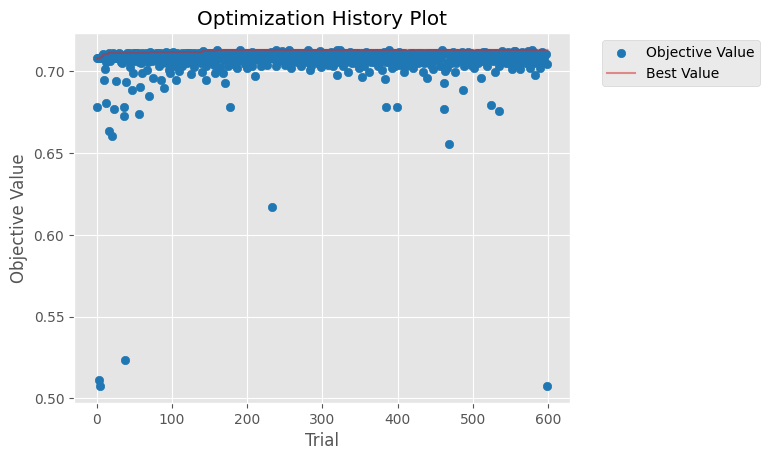

"\n# Plot validation accuracy over time (custom plot)\nplt.figure(figsize=(6, 4))\nplt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, marker='o', linestyle='-', color='b')\nplt.title('Validation Accuracy Over Trials')\nplt.xlabel('Trial')\nplt.ylabel('Validation Accuracy')\nplt.grid(True)\nplt.show()\n"

In [28]:
import optuna
import matplotlib.pyplot as plt
from optuna.visualization.matplotlib import plot_optimization_history
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Objective function to optimize with Optuna
def objective(trial):
    # Suggest values for hyperparameters
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs'])
    C = trial.suggest_float('C', 1e-6, 1e3, log=True)  # Regularization strength
    max_iter = trial.suggest_int('max_iter', 100, 2000)
    
    # Create the Logistic Regression model with suggested hyperparameters
    model = LogisticRegression(solver=solver, C=C, max_iter=max_iter, random_state=42)
    
    # Perform cross-validation to get an evaluation score
    score = cross_val_score(model, x_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    
    # Append the validation accuracy for each trial to the list
    validation_accuracies.append(score)
    
    return score

# Create a list to store validation accuracies for each trial
validation_accuracies = []

# Create the Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=600)

# Output the best hyperparameters found by Optuna
print("Best hyperparameters:")
print(study.best_params)

# Train the Logistic Regression model using the best hyperparameters
best_params = study.best_params
LR_model_HP = LogisticRegression(**best_params, random_state=42)
LR_model_HP.fit(x_train_scaled, y_train)

# Make predictions on the validation set
y_val_pred = LR_model_HP.predict(x_val_scaled)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy with tuned hyperparameters: {accuracy:.4f}")

# Plot the optimization history (from Optuna)
opt_history_fig = plot_optimization_history(study)
plt.show()

"""
# Plot validation accuracy over time (custom plot)
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, marker='o', linestyle='-', color='b')
plt.title('Validation Accuracy Over Trials')
plt.xlabel('Trial')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()
"""

Validation Statistics:

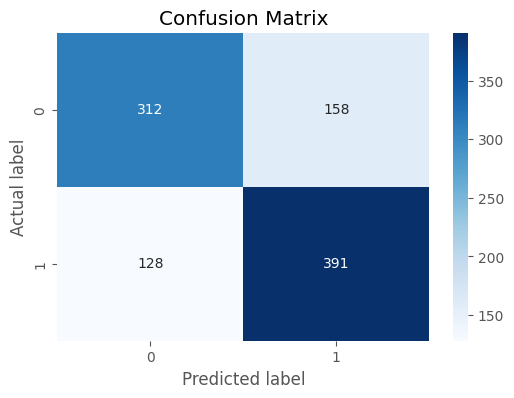

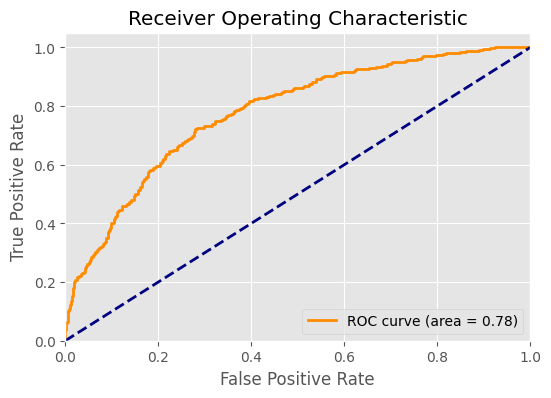

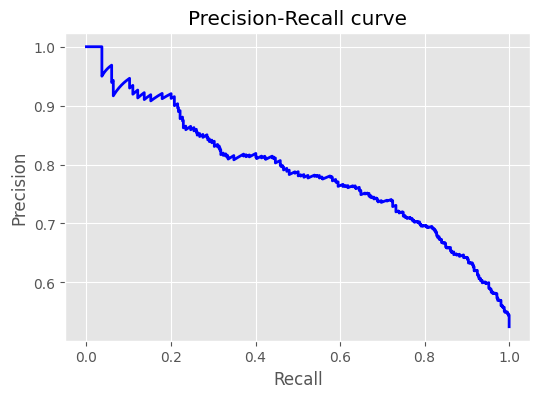

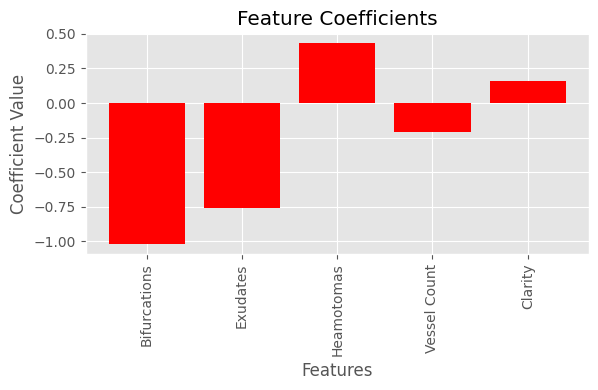

In [29]:
#plot_linear_model_evaluation_statistics(LR_model_HP, X_val_scaled, y_val)
plot_linear_model_evaluation_statistics(LR_model, x_val_scaled, y_val)

Testing Statistics:

In [30]:
# Make predictions on the testing set
y_test_pred = LR_model.predict(x_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {accuracy:.4f}")

Testing Accuracy: 0.6967


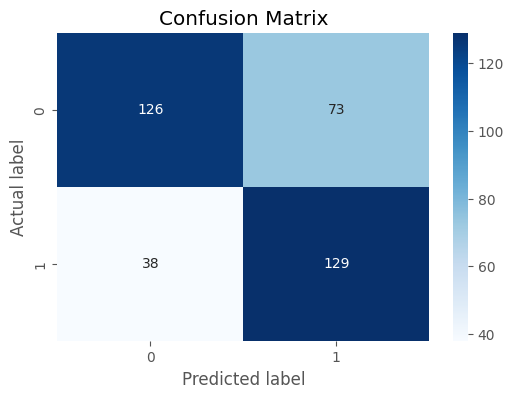

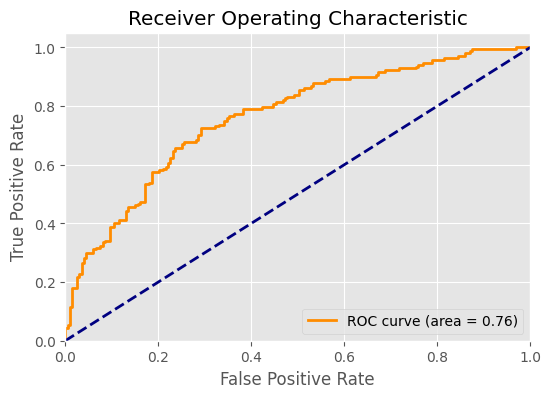

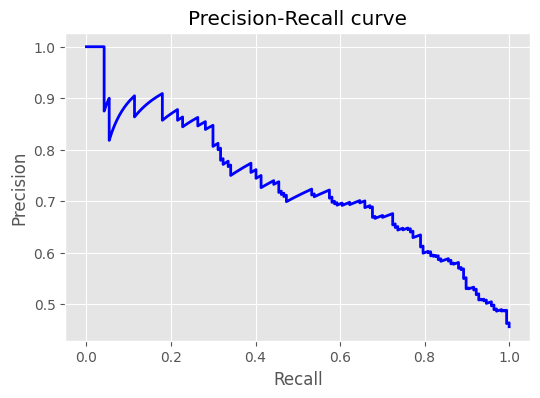

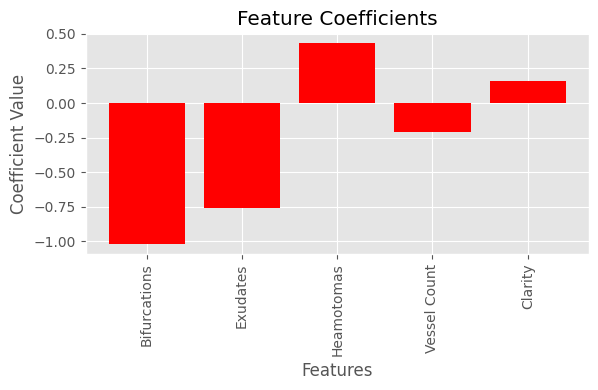

In [31]:
plot_linear_model_evaluation_statistics(LR_model, x_test_scaled, y_test)

#### 2. Random Forrest:

##### 2.1 Randdom Forrest Classifier: 

Training the Model:

In [32]:
# Creating a random forest model and testing it's accuracy on the validation data

random_forest_model = RandomForestClassifier(n_estimators=1000, random_state=42)  # n_estimators is the number of trees

random_forest_model.fit(x_train_scaled, y_train)

y_pred = random_forest_model.predict(x_val_scaled)

accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.7937


Validation Statistics:

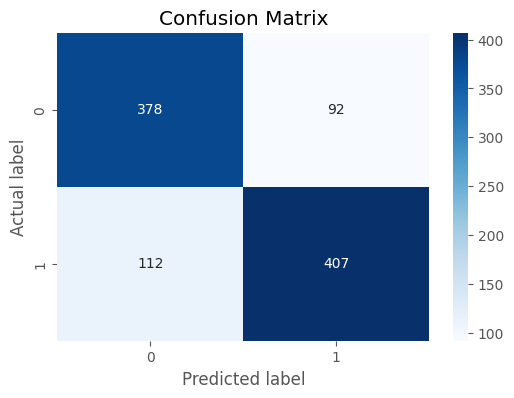

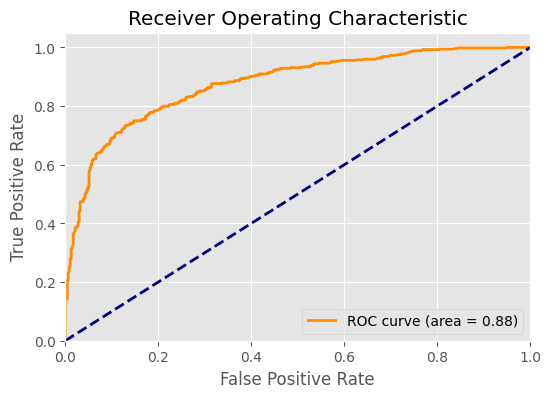

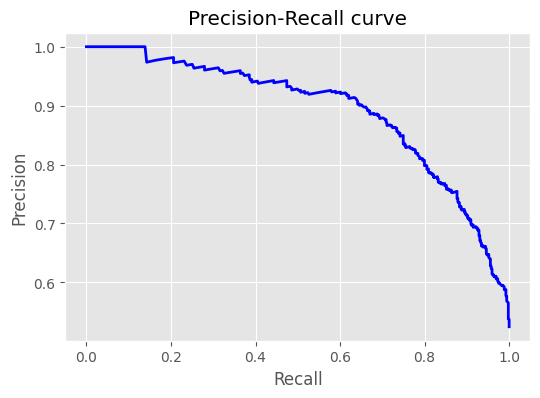

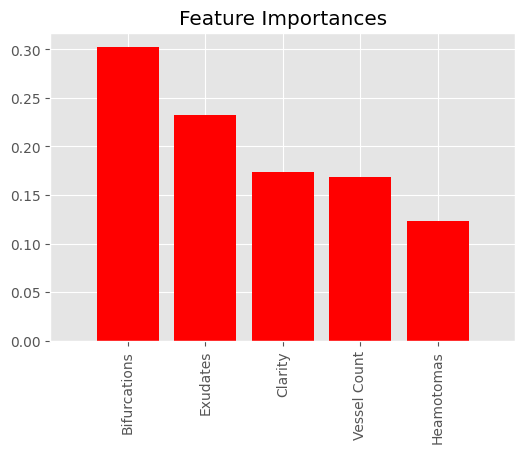

In [33]:
plot_model_evaluation_statistics(random_forest_model, x_val_scaled, y_val)

Testing Statistics:

In [85]:
# Make predictions on the testing set
y_test_pred = random_forest_model.predict(x_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {accuracy:.4f}")

Testing Accuracy: 0.7978


In [86]:
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"F1 Score: {f1}")

F1 Score: 0.7978142076502732


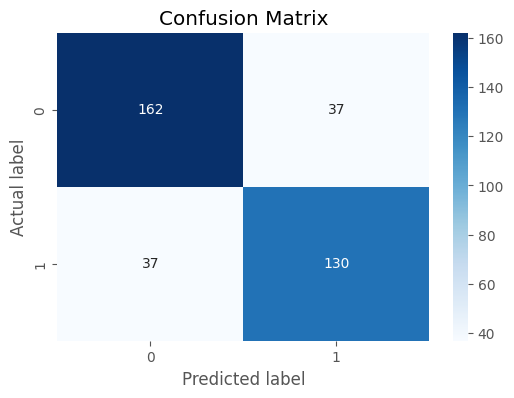

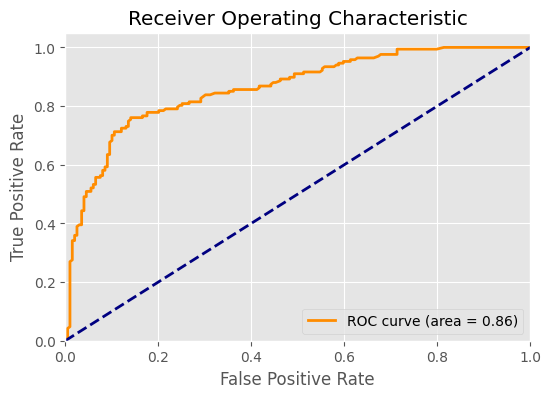

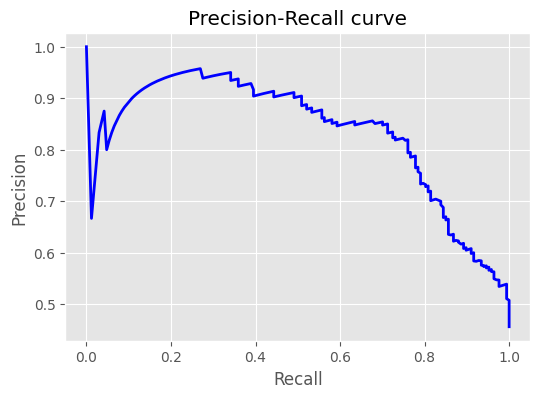

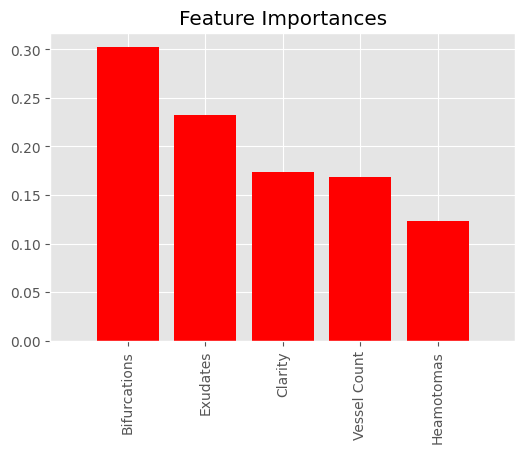

In [35]:
plot_model_evaluation_statistics(random_forest_model, x_test_scaled, y_test)

##### 2.2 Random Forrest Regressor with Cutoff:

In [36]:
# Initialise random forrest regressor
randForest_regressor = RandomForestRegressor(n_estimators=1000, random_state=42)

# Train the model
randForest_regressor.fit(x_train_scaled, y_train)

# Predict on validation data
y_pred = randForest_regressor.predict(x_val_scaled)

# Calculate RMSE (Root Mean Squared Error)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Validation RMSE: {rmse:.4f}")

# Calculate R^2 score
r2_score = randForest_regressor.score(x_val_scaled, y_val)
print(f"Validation R^2 Score: {r2_score:.4f}")

c:\Users\Kaylin\OneDrive\Documents\Fourth Year IE 2024\Investigation Project\ELEN4012A-Investigation-Project\InvestigationEnv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Validation RMSE: 0.3834
Validation R^2 Score: 0.4105


Hyperparameter Tuning using Optuna:

In [ ]:
"""
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Objective function for Optuna to minimize
def objective(trial):
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    # Create the RandomForestRegressor model with suggested hyperparameters
    randForest_regressor = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    # Perform cross-validation (you can adjust `cv` for more or fewer folds)
    score = cross_val_score(randForest_regressor, x_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

    # Return the negative RMSE (because Optuna maximizes by default)
    return score

# Create the Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Output the best hyperparameters found by Optuna
print("Best hyperparameters:")
print(study.best_params)

# Train the RandomForestRegressor model using the best hyperparameters
best_params = study.best_params
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(x_train_scaled, y_train)

# Predict on the validation set
y_val_pred = best_model.predict(x_val_scaled)

# Calculate RMSE on the validation set
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print(f"Validation RMSE with tuned hyperparameters: {rmse:.4f}")

# Calculate R² score
r2_score = best_model.score(x_val_scaled, y_val)
print(f"Validation R² Score with tuned hyperparameters: {r2_score:.4f}")
"""

Plot the Predictions to Understand the Binary Clustering and Cutoff Point:

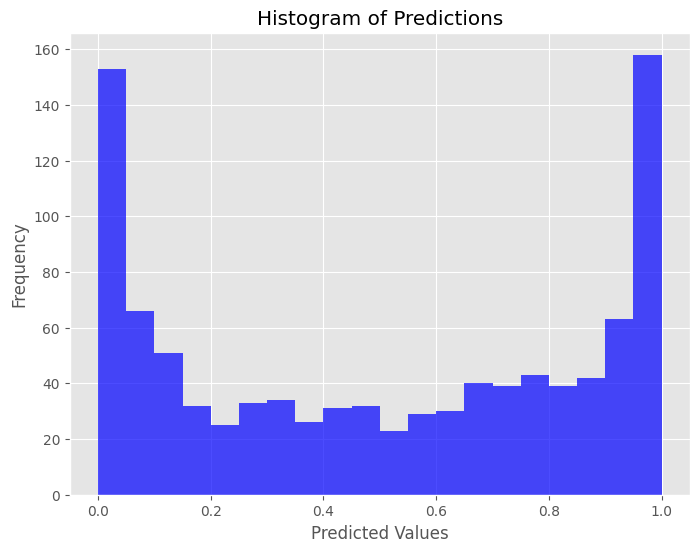

In [37]:
# Plot histogram of predictions
plt.figure(figsize=(8, 6))
plt.hist(y_pred, bins=20, color='blue', alpha=0.7)
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.title('Histogram of Predictions')
plt.grid(True)
plt.show()

In [38]:
cutoff_threshold_val = np.median(y_pred)
print(cutoff_threshold_val)

0.524


In [39]:
binary_predictions = np.where(y_pred > cutoff_threshold_val, 1, 0)

Validation Statistics:

Validation Accuracy (with cutoff 0.524): 0.7907


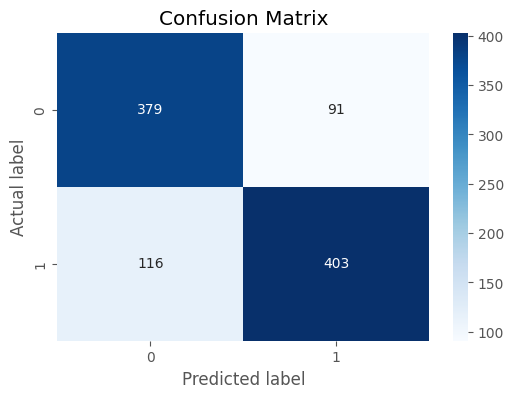

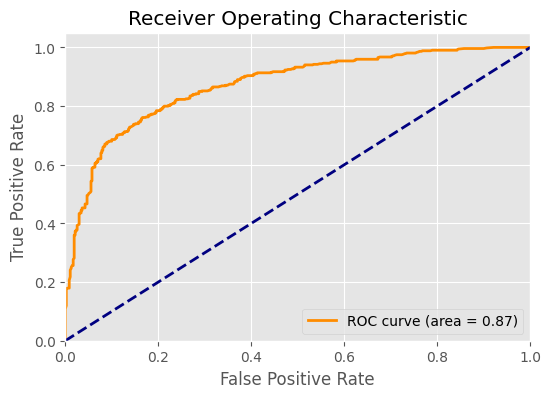

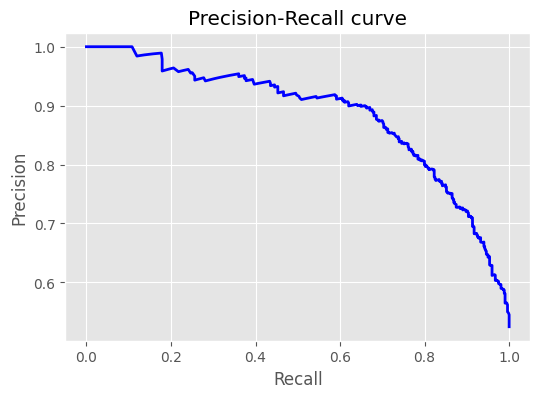

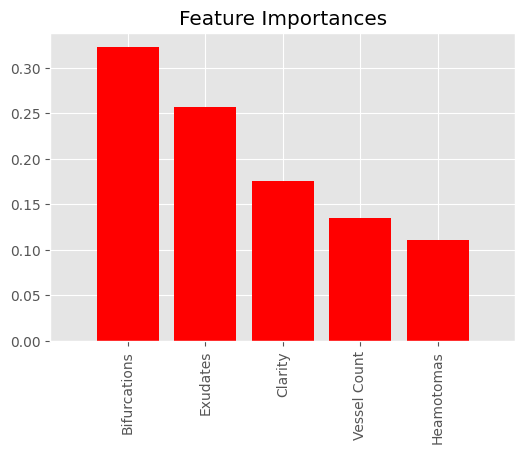

In [40]:
plot_regression_evaluation_statistics(randForest_regressor, x_val_scaled, y_val, cutoff_threshold=cutoff_threshold_val)

Testing Statistics:

Validation Accuracy (with cutoff 0.524): 0.8142


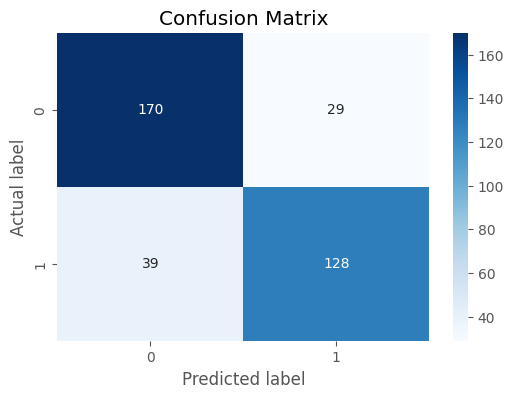

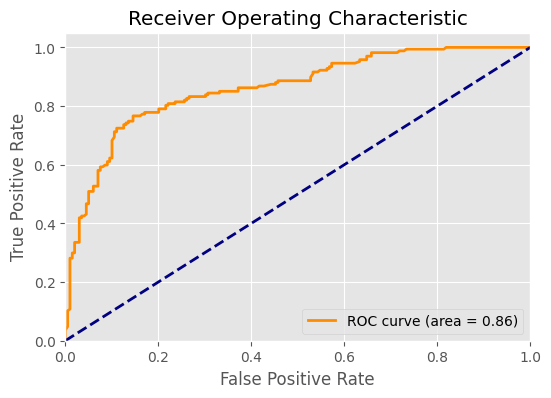

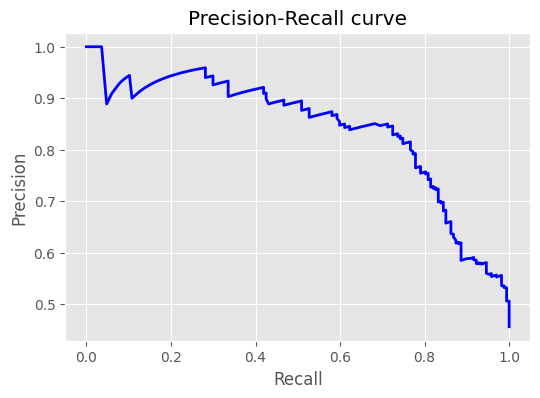

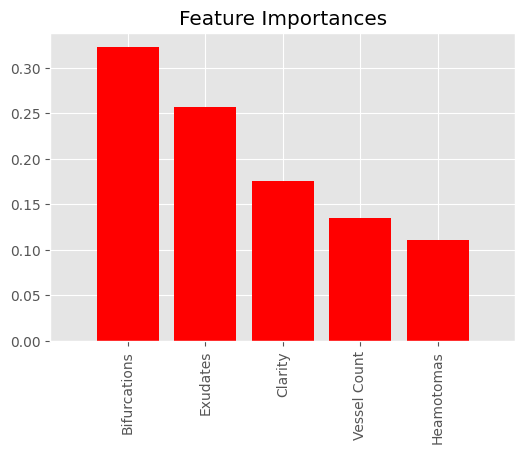

In [41]:
# Make predictions on the testing set
y_test_pred = randForest_regressor.predict(x_test_scaled)

plot_regression_evaluation_statistics(randForest_regressor, x_test_scaled, y_test, cutoff_threshold=cutoff_threshold_val)

#### 3. Naive Bayes:

##### 3.1 Multinomial Naive Bayes:

Training the Model:

In [42]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the model
mnb = MultinomialNB()

# Train the model
mnb.fit(x_train, y_train)

# Predict on the validation set
y_val_pred = mnb.predict(x_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.6006


Validation Statistics:

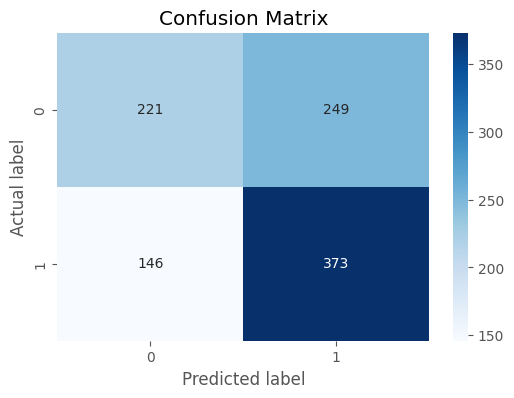

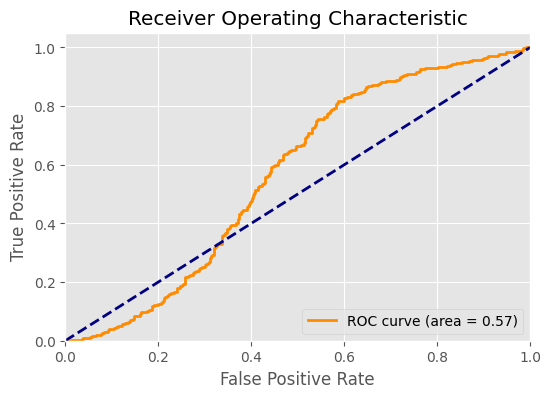

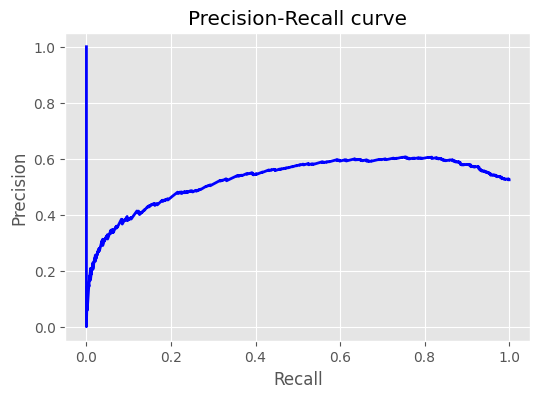

In [43]:
plot_linear_model_evaluation_statistics(mnb, x_val, y_val)

Testing Statistics:

In [44]:
# Predict on the validation set
y_test_pred = mnb.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5519


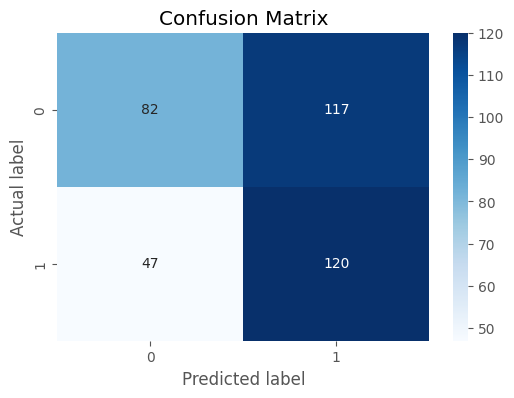

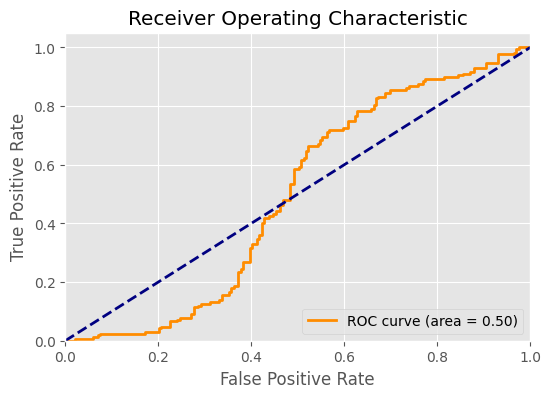

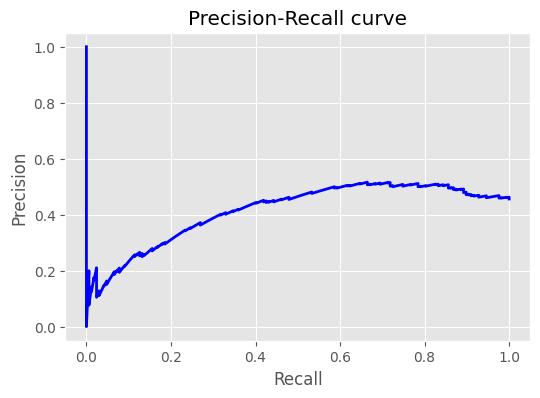

In [45]:
plot_linear_model_evaluation_statistics(mnb, x_test, y_test)

##### 3.2 Gaussian Naive Bayes:

Training the Model:

In [46]:
from sklearn.naive_bayes import GaussianNB

# Train the Naive Bayes model on the training set
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(x_train_scaled, y_train)

# Make predictions on testing data set
y_pred = naive_bayes_model.predict(x_val_scaled)

# Find the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.7058


Validation Statistics:

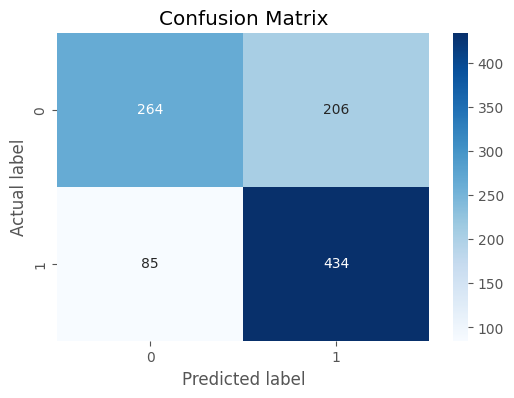

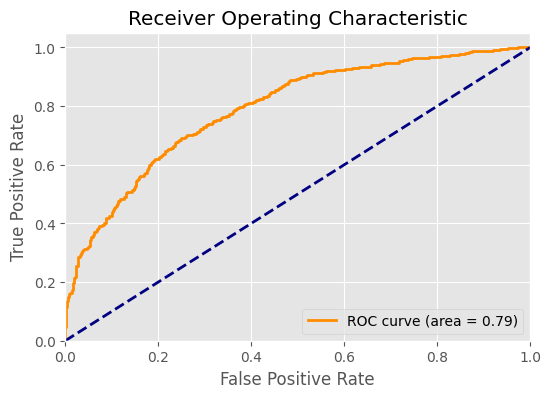

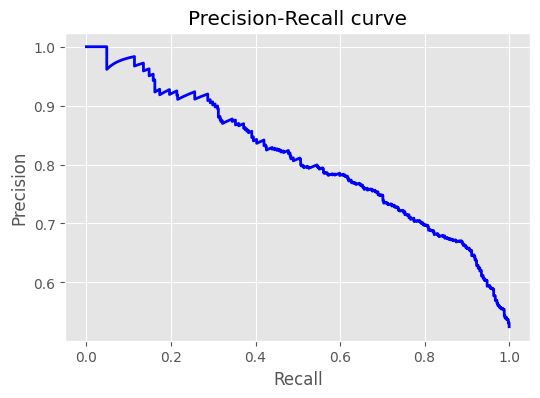

In [47]:
plot_linear_model_evaluation_statistics(naive_bayes_model, x_val_scaled, y_val)

Testing Statistics:

In [48]:
# Make predictions on testing data set
y_pred = naive_bayes_model.predict(x_test_scaled)

# Find the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Testing Accuracy: {accuracy:.4f}")

Testing Accuracy: 0.6831


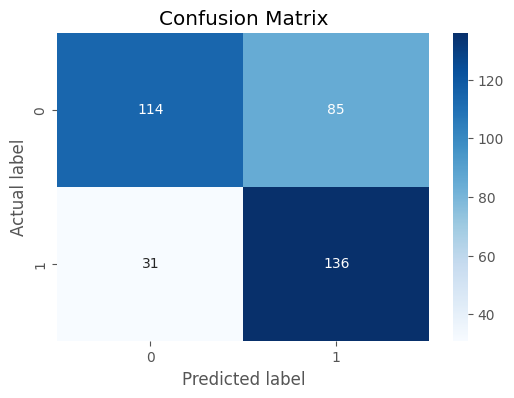

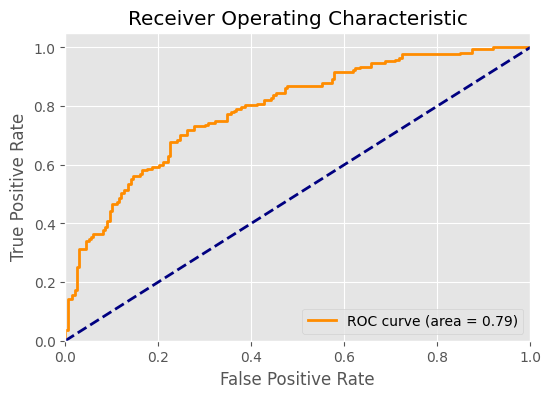

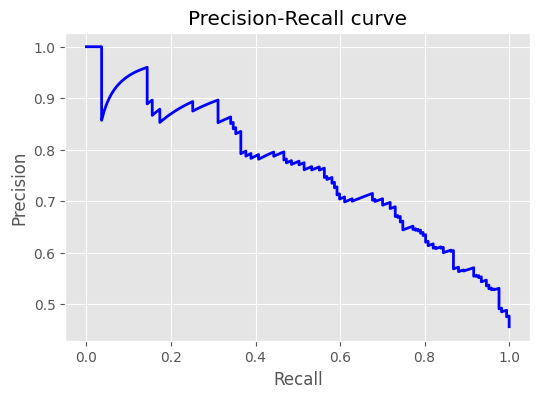

In [49]:
plot_linear_model_evaluation_statistics(naive_bayes_model, x_test_scaled, y_test)

#### 4. XGBoost:

##### 4.1 XGBoost Classifier:

Training the Model:

In [96]:
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier()

# Train the model
xgb_model.fit(x_train_scaled, y_train)

# Predict on validation data
y_pred = xgb_model.predict(x_val_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.7927


Hyper-parameter Tuning using Optuna:

In [ ]:
"""
import optuna
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Objective function for Optuna to minimize
def objective(trial):
    # Suggest values for hyperparameters
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',  # Assuming binary classification
        'eval_metric': 'logloss',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Create the XGBoost model with suggested hyperparameters
    xgb_model = xgb.XGBClassifier(**param, use_label_encoder=False)

    # Perform cross-validation
    score = cross_val_score(xgb_model, x_train_scaled, y_train, cv=5, scoring='accuracy').mean()

    return score

# Create the Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Output the best hyperparameters found by Optuna
print("Best hyperparameters:")
print(study.best_params)

# Train the XGBoost model using the best hyperparameters
best_params = study.best_params
xgb_best_model = xgb.XGBClassifier(**best_params, use_label_encoder=False)
xgb_best_model.fit(x_train_scaled, y_train)

# Predict on the validation set
y_val_pred = xgb_best_model.predict(x_val_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy with tuned hyperparameters: {accuracy:.4f}")
"""

Validation Statistics: 

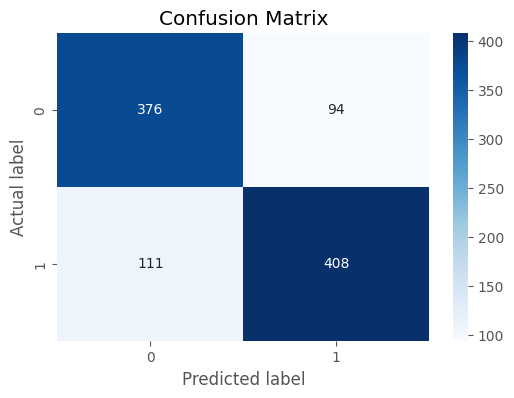

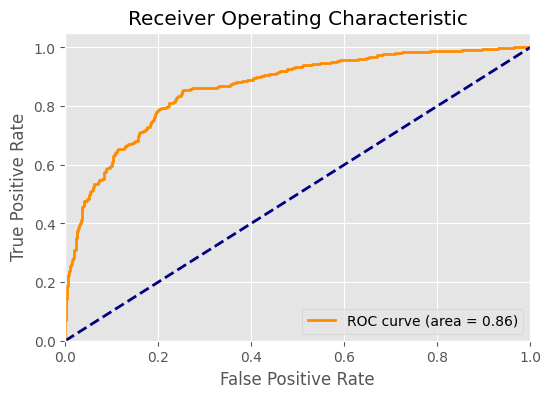

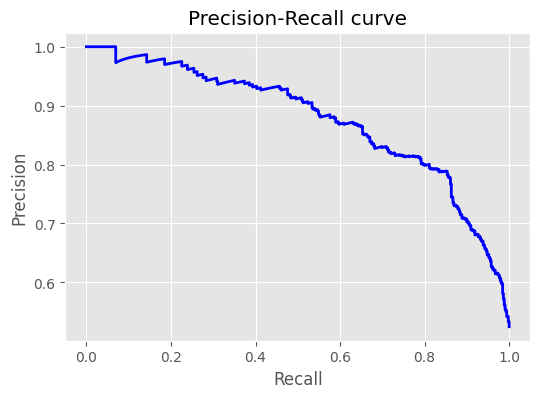

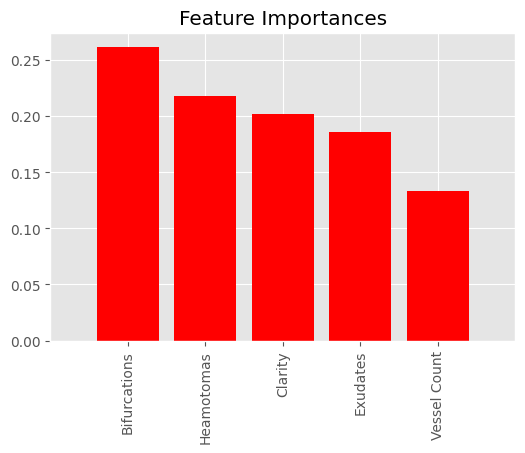

In [51]:
plot_model_evaluation_statistics(xgb_model, x_val_scaled, y_val)

Testing Statistics:

In [97]:
# Predict on the test set
y_test_pred = xgb_model.predict(x_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7814


In [98]:
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"F1 Score: {f1}")

F1 Score: 0.7814207650273224


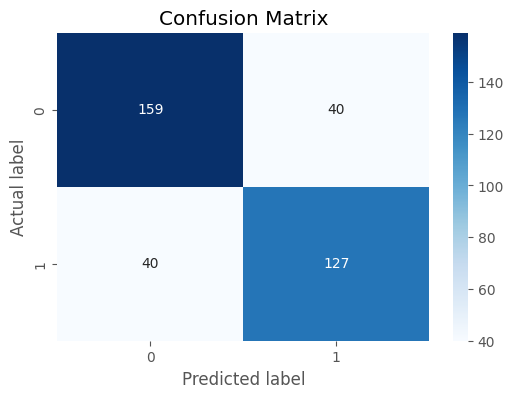

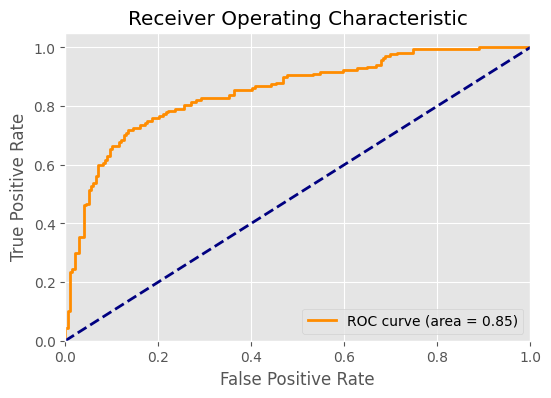

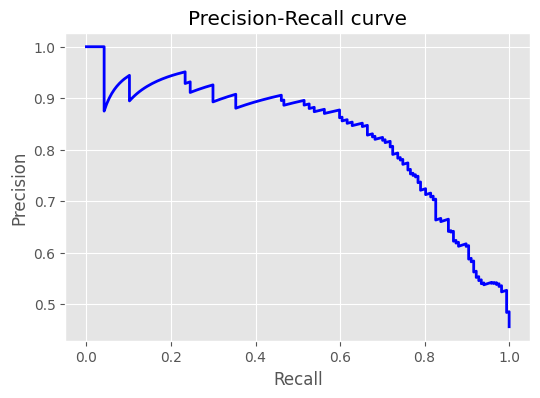

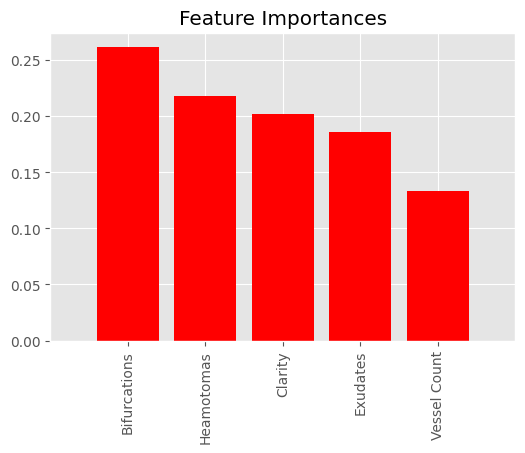

In [53]:
plot_model_evaluation_statistics(xgb_model, x_test_scaled, y_test)

##### 4.2 XGBoost Regressor:

Training the model:

In [54]:
# Initialize XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Train the model
xgb_regressor.fit(x_train_scaled, y_train)

# Predict on validation data
y_pred = xgb_regressor.predict(x_val_scaled)

# Calculate RMSE (Root Mean Squared Error)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Validation RMSE: {rmse:.4f}")

# Calculate R^2 score
r2_score = xgb_regressor.score(x_val_scaled, y_val)
print(f"Validation R^2 Score: {r2_score:.4f}")

Validation RMSE: 0.4088
Validation R^2 Score: 0.3299


c:\Users\Kaylin\OneDrive\Documents\Fourth Year IE 2024\Investigation Project\ELEN4012A-Investigation-Project\InvestigationEnv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


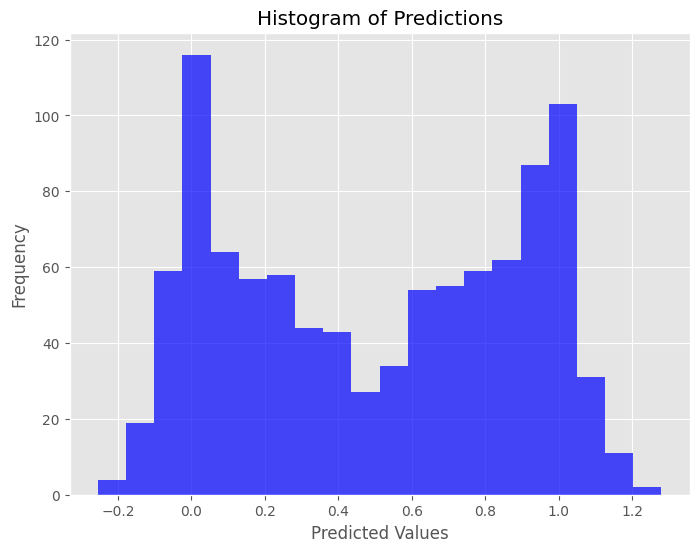

In [55]:
# Plot histogram of predictions
plt.figure(figsize=(8, 6))
plt.hist(y_pred, bins=20, color='blue', alpha=0.7)
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.title('Histogram of Predictions')
plt.grid(True)
plt.show()

In [56]:
cutoff_threshold_val = np.median(y_pred)
print(cutoff_threshold_val)

0.5202989


In [57]:
binary_predictions = np.where(y_pred > cutoff_threshold_val, 1, 0)

Validation Statistics:

Validation Accuracy (with cutoff 0.5202988982200623): 0.7786


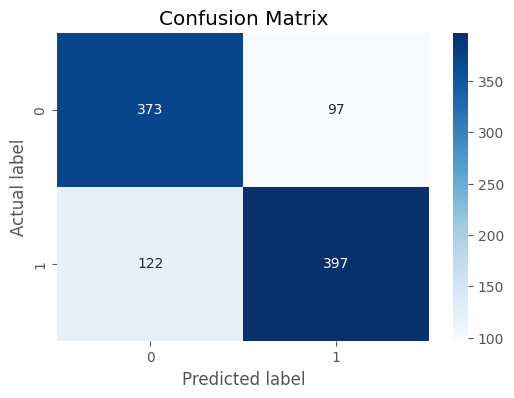

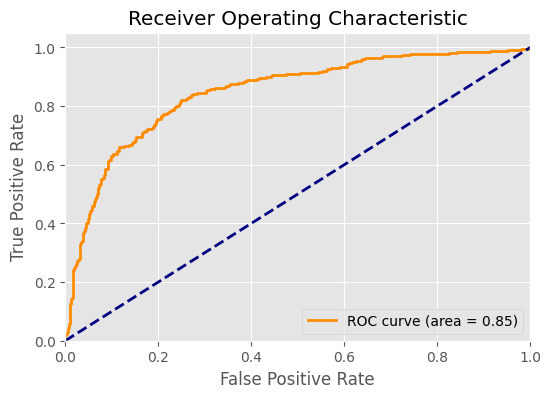

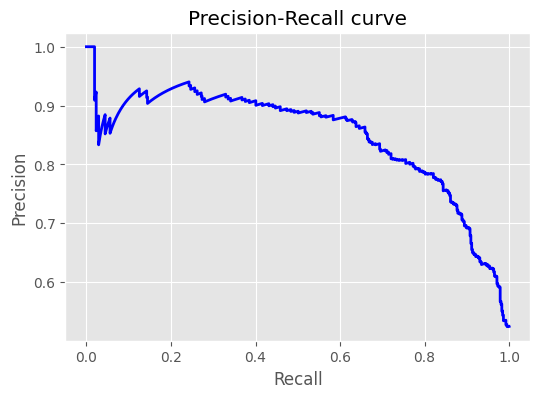

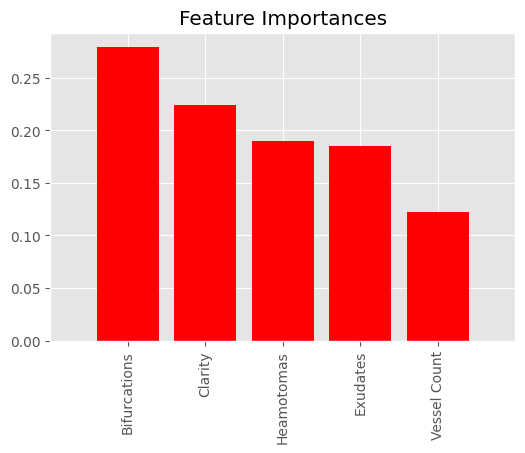

In [58]:
plot_regression_evaluation_statistics(xgb_regressor, x_val_scaled, y_val, cutoff_threshold=cutoff_threshold_val)

Testing Statistics:

Validation Accuracy (with cutoff 0.5202988982200623): 0.7896


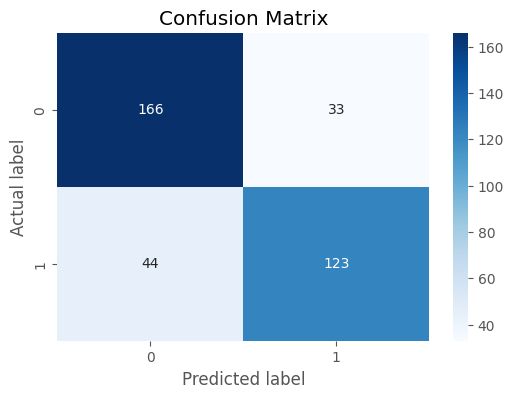

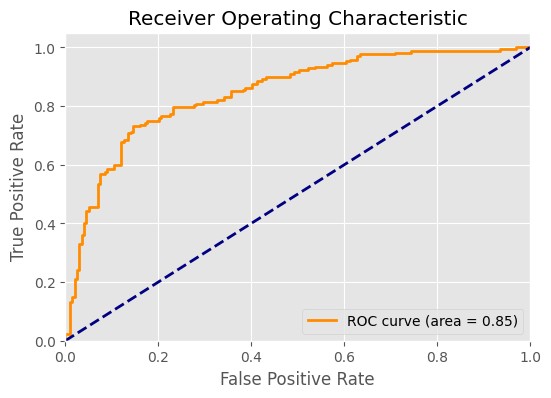

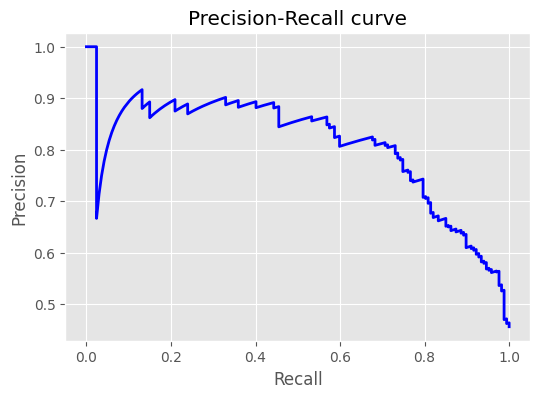

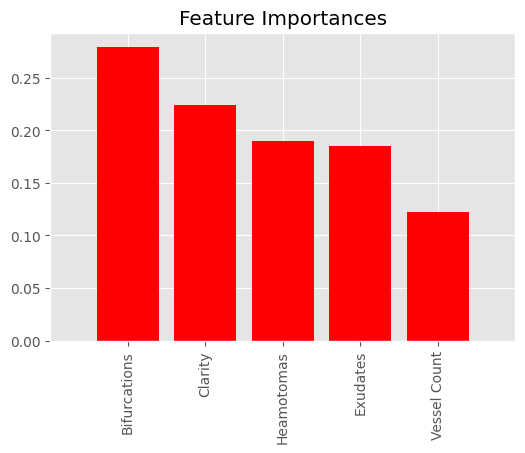

In [59]:
# Make predictions on the testing set
y_test_pred = xgb_regressor.predict(x_test_scaled)

plot_regression_evaluation_statistics(xgb_regressor, x_test_scaled, y_test, cutoff_threshold=cutoff_threshold_val)

#### 5. Gradient Boosting:

##### 5.1 Gradient Boosting Classifier:

Training the Model:

In [60]:
# Initialize GradientBoostingClassifier model
gb_model = GradientBoostingClassifier()

# Train the model
gb_model.fit(x_train_scaled, y_train)

# Predict on validation data
y_pred = gb_model.predict(x_val_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.7927


Validation Statistics:

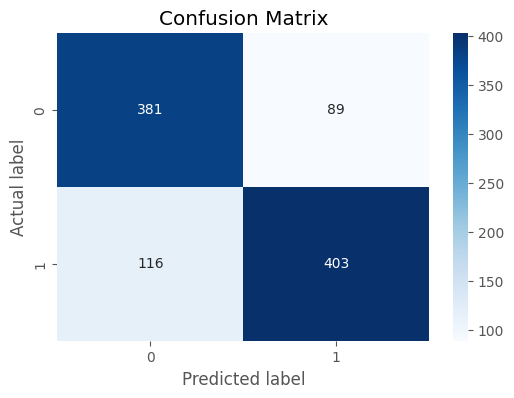

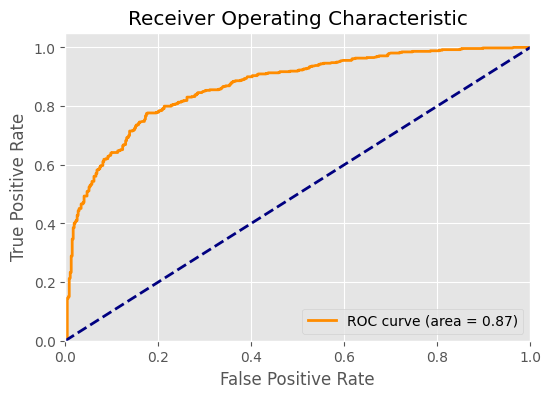

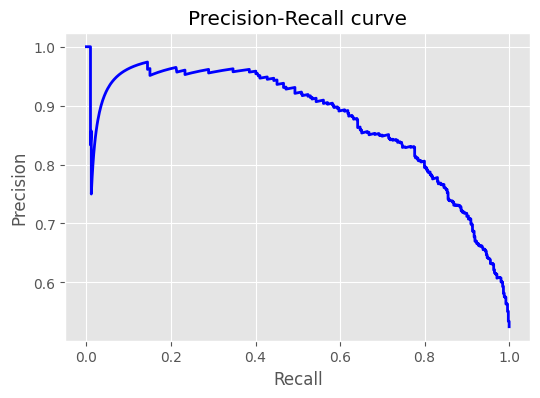

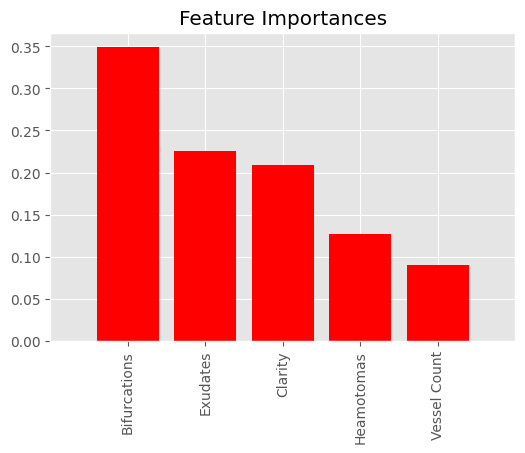

In [61]:
plot_model_evaluation_statistics(gb_model, x_val_scaled, y_val)

Testing Statistics:

In [80]:
# Predict on testing data
y_test_pred = gb_model.predict(x_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {accuracy:.4f}")

Testing Accuracy: 0.8033


In [99]:
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"F1 Score: {f1}")

F1 Score: 0.7814207650273224


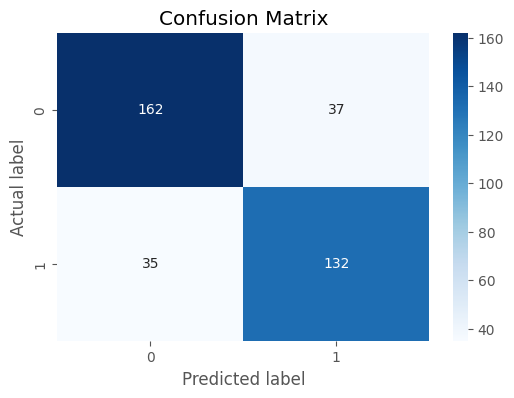

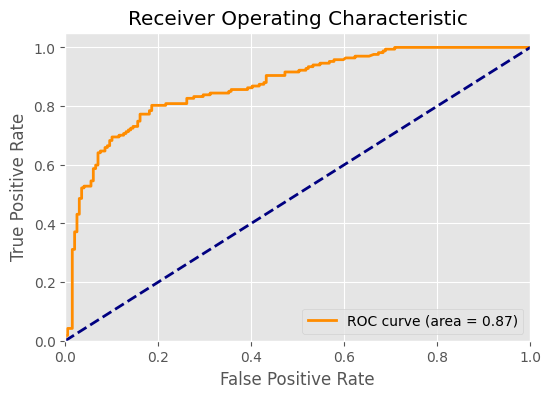

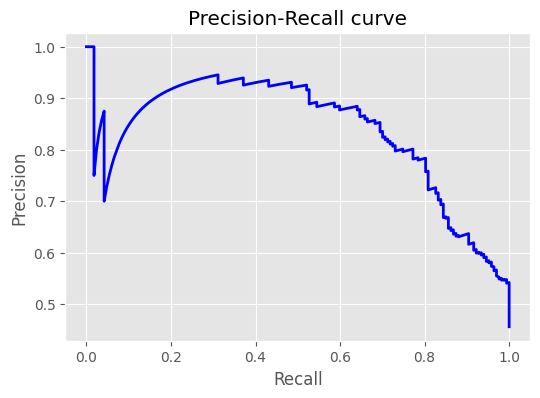

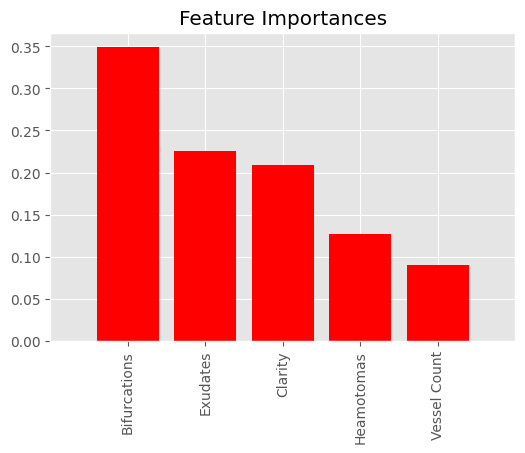

In [63]:
plot_model_evaluation_statistics(gb_model, x_test_scaled, y_test)

##### 5.2 Gradient Boosting Regressor:

Training the Model:

In [64]:
# Initialize GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor()

# Train the model
gb_regressor.fit(x_train_scaled, y_train)

# Predict on validation data
y_pred = gb_regressor.predict(x_val_scaled)

# Calculate RMSE (Root Mean Squared Error)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Validation RMSE: {rmse:.4f}")

# Calculate R^2 score
#r2 = r2_score(y_val, y_pred)
#print(f"Validation R^2 Score: {r2:.4f}")

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_val, y_pred)
print(f"Validation MAE: {mae:.4f}")

Validation RMSE: 0.3884
Validation MAE: 0.2970


c:\Users\Kaylin\OneDrive\Documents\Fourth Year IE 2024\Investigation Project\ELEN4012A-Investigation-Project\InvestigationEnv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


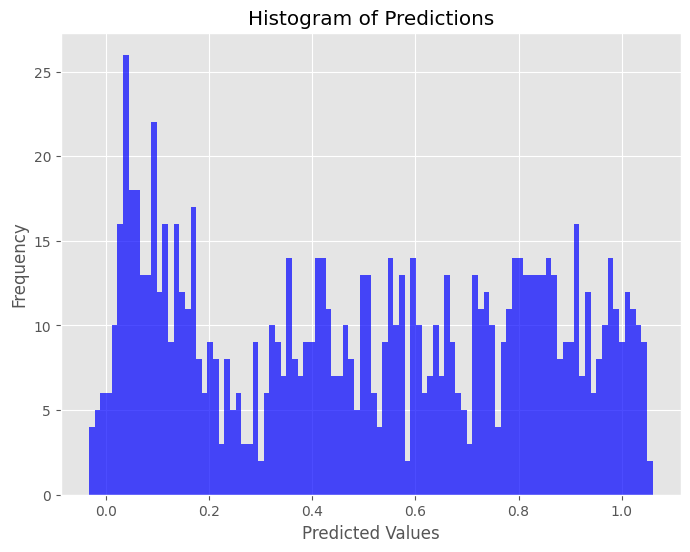

In [65]:
# Plot histogram of predictions
plt.figure(figsize=(8, 6))
plt.hist(y_pred, bins=100, color='blue', alpha=0.7)
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.title('Histogram of Predictions')
plt.grid(True)
plt.show()

In [66]:
cutoff_threshold_val = np.median(y_pred)
print(cutoff_threshold_val)

0.5083757996702171


In [67]:
binary_predictions = np.where(y_pred > cutoff_threshold_val, 1, 0)

Validation Statistics:

Validation Accuracy (with cutoff 0.5083757996702171): 0.7947


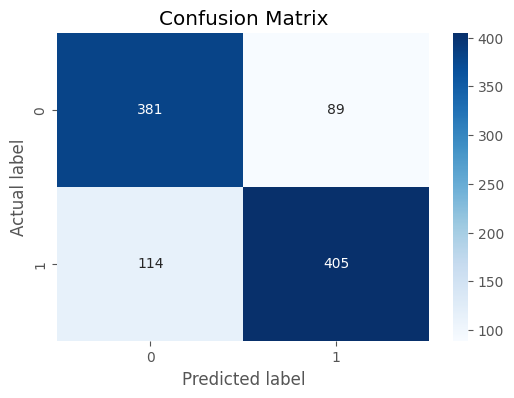

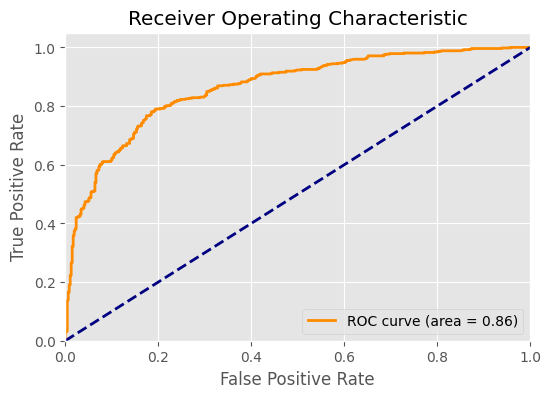

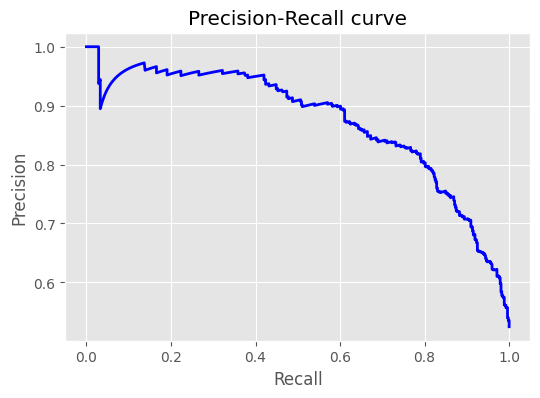

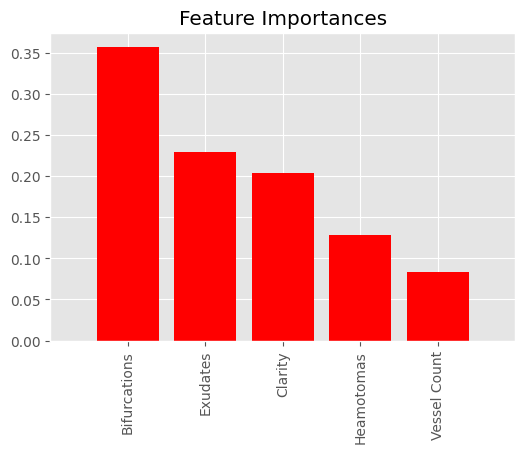

In [68]:
plot_regression_evaluation_statistics(gb_regressor, x_val_scaled, y_val, cutoff_threshold=cutoff_threshold_val)

Testing Statistics:

Validation Accuracy (with cutoff 0.5083757996702171): 0.8005


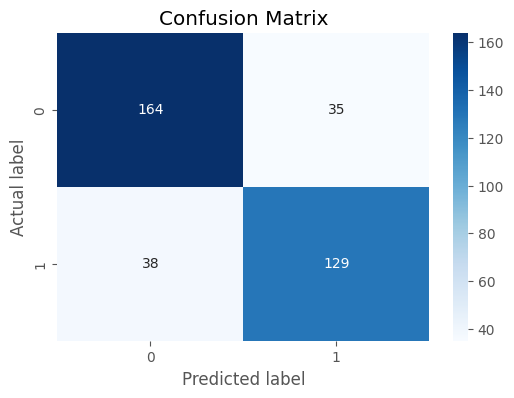

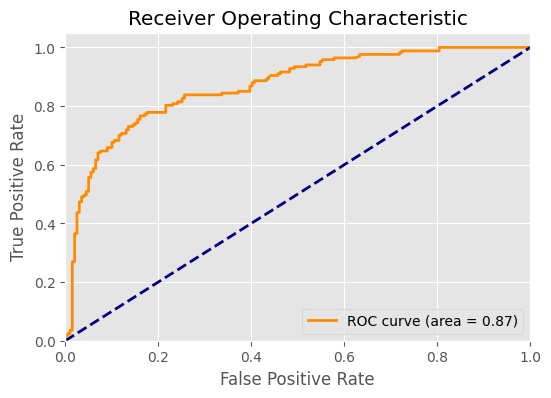

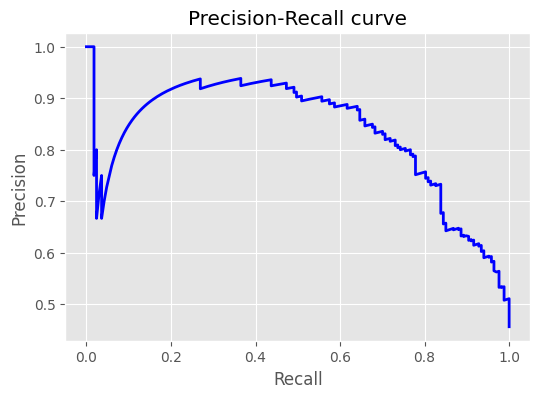

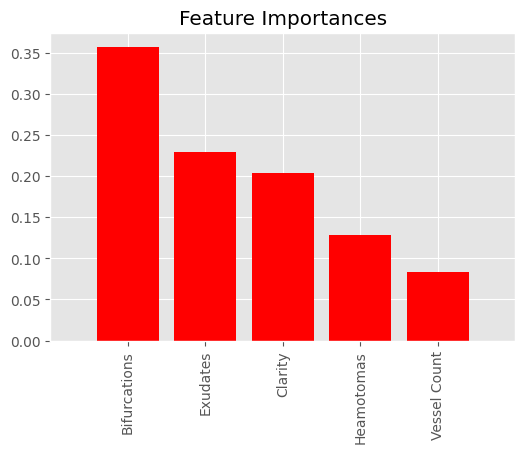

In [69]:
# Predict on validation data
y_test_pred = gb_regressor.predict(x_test_scaled)
binary_predictions = np.where(y_test_pred > cutoff_threshold_val, 1, 0)

plot_regression_evaluation_statistics(gb_regressor, x_test_scaled, y_test, cutoff_threshold=cutoff_threshold_val)

#### 6. SVM:

##### 6.1 SVM with Linear Kernel:

Training the model:

In [89]:
# Step 1: Create the SVM model
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Step 2: Train the model on the scaled training data
svm_model.fit(x_train_scaled, y_train)

# Step 3: Make predictions on the validation set
y_val_pred = svm_model.predict(x_val_scaled)

accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 72.09%


Validation Statistics:

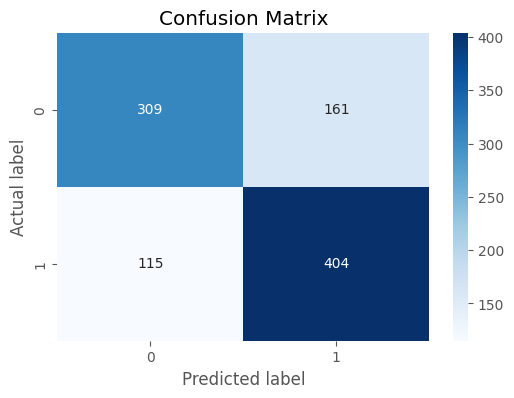

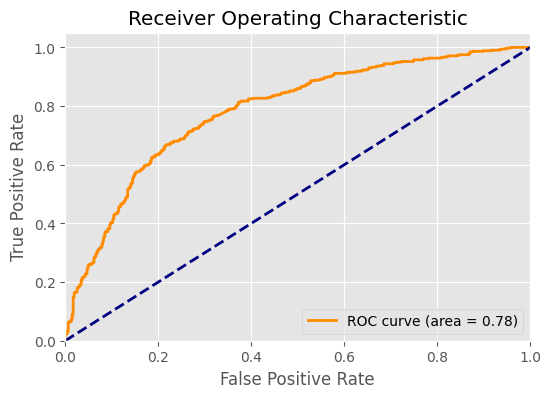

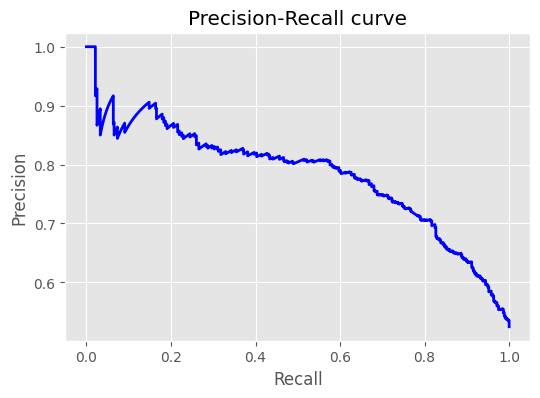

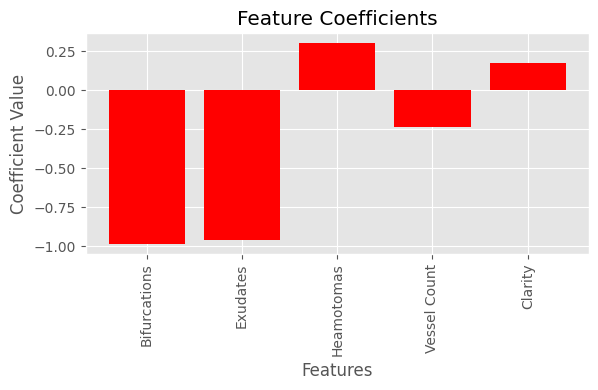

In [90]:
plot_linear_model_evaluation_statistics(svm_model, x_val_scaled, y_val)

Testing Statistics:

In [91]:
y_test_pred = svm_model.predict(x_test_scaled)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {accuracy * 100:.2f}%")

Testing Accuracy: 71.31%


In [92]:
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"F1 Score: {f1}")

F1 Score: 0.7127184771311775


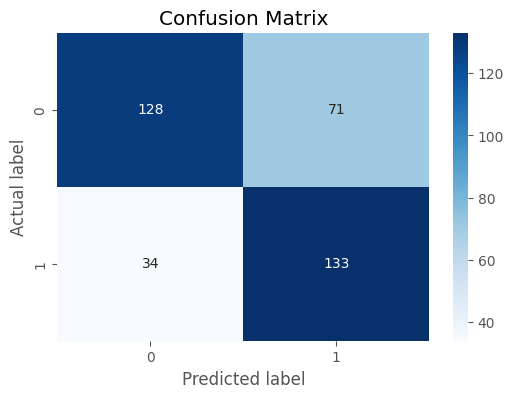

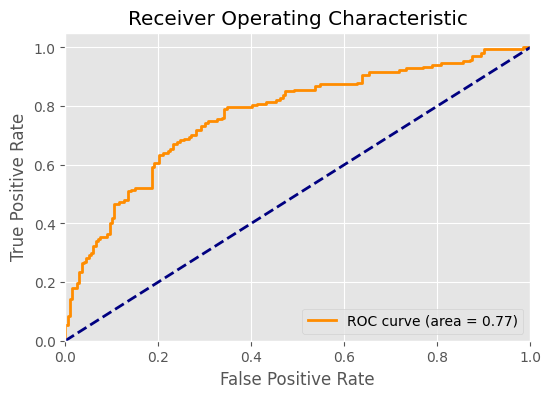

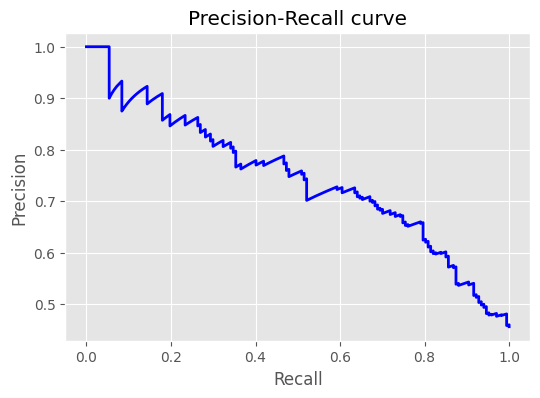

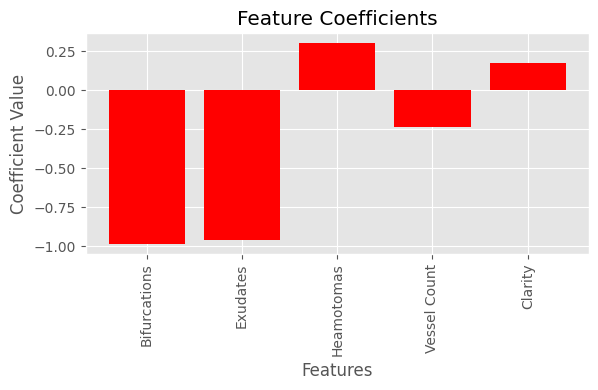

In [73]:
plot_linear_model_evaluation_statistics(svm_model, x_test_scaled, y_test)

##### 6.2 SVM with RBF Kernel:

Training the Model:

In [93]:
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Step 2: Train the model on the scaled training data
svm_model.fit(x_train_scaled, y_train)

# Step 3: Make predictions on the validation set
y_val_pred = svm_model.predict(x_val_scaled)

accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 78.87%


Validation Statistics:

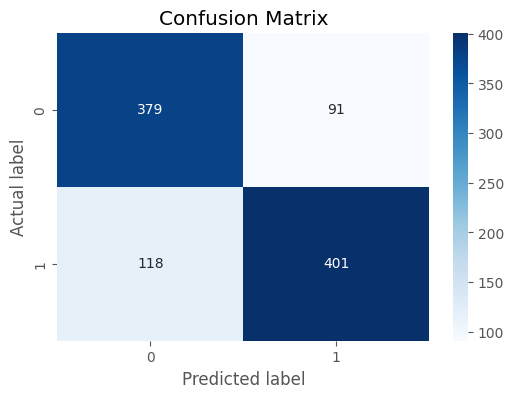

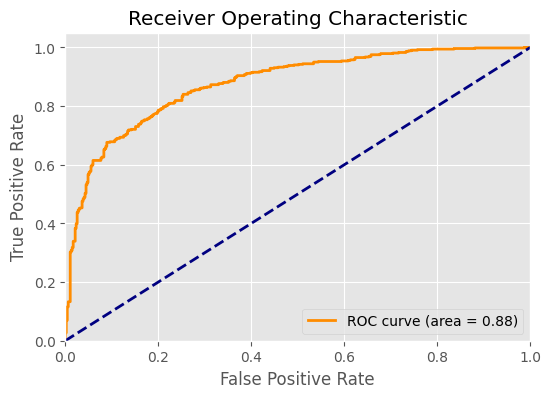

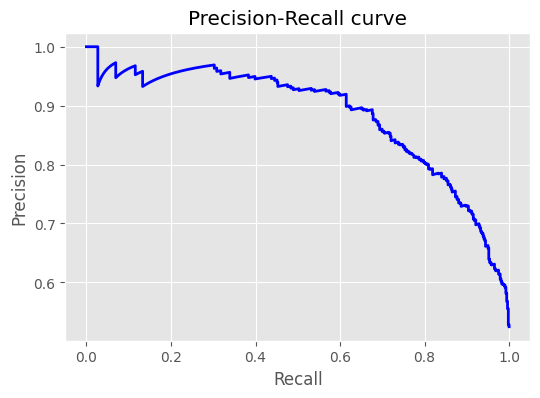

AttributeError: 'SVC' object has no attribute 'feature_importances_'

<Figure size 600x400 with 0 Axes>

In [75]:
plot_model_evaluation_statistics(svm_model, x_val_scaled, y_val)

Testing Statistics:

In [94]:
y_test_pred = svm_model.predict(x_test_scaled)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {accuracy * 100:.2f}%")

Testing Accuracy: 78.69%


In [95]:
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"F1 Score: {f1}")

F1 Score: 0.7870644791673335


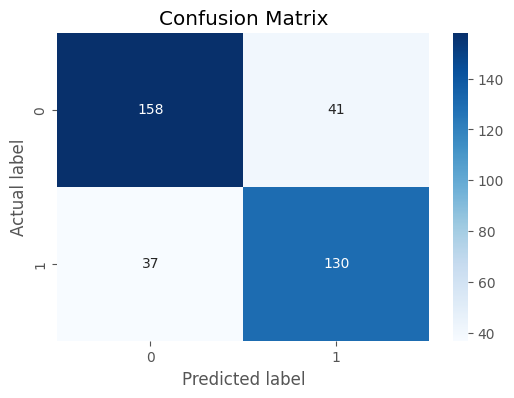

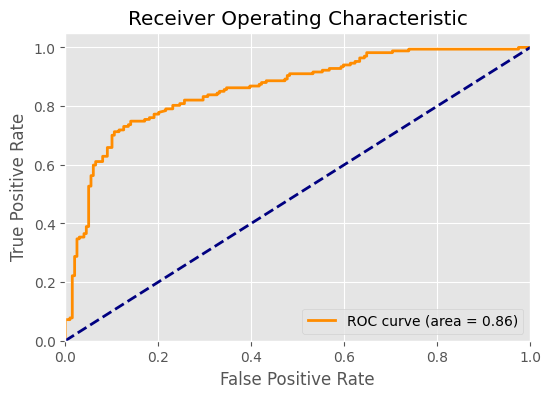

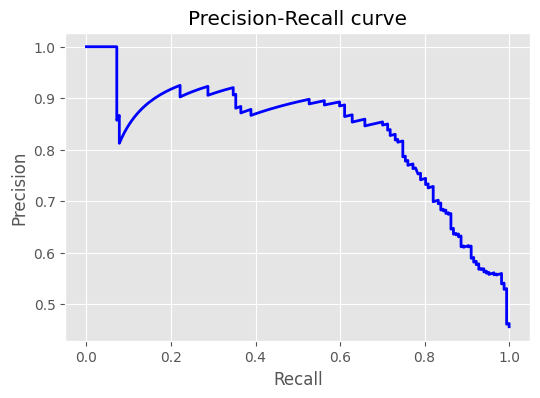

AttributeError: 'SVC' object has no attribute 'feature_importances_'

<Figure size 600x400 with 0 Axes>

In [77]:
plot_model_evaluation_statistics(svm_model, x_test_scaled, y_test)

#### 7. Neural Network:

#### 8. Combination Model: